## Use the following command to run trainning
Modified config.py file for different parameters

python train.py

In [1]:
import sys, os

import numpy as np

import pickle

import torch
import torch.nn.functional as F
from pytorch_msssim import MS_SSIM
from tqdm import tqdm


import model, generator

import pandas as pd
import matplotlib.pyplot as plt




## Loading model's config
FOLDER_PATH shows the model you want to test

In [2]:
FOLDER_PATH = "/home/garysnake/Desktop/crsae/pytorch/results/default/64_conv_50_depth/"
HYP_PATH = FOLDER_PATH+"hyp.pickle"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

file = open(HYP_PATH, "rb")
hyper_parameter = pickle.load(file)
file.close()
for name, val in hyper_parameter.items():
    print(str(name) + ": " + str(val))
    
    
# Loading Model
MODEL_PATH = FOLDER_PATH+"model_epoch29.pt"
result_model = torch.load(MODEL_PATH)


experiment_name: default
dataset: VOC
network: CRsAE2DUntiedTrainableBias
dictionary_dim: 7
num_conv: 64
stride: 6
L: 5
trainable_bias: True
delta: 50
num_iters: 50
batch_size: 1
num_epochs: 30
normalize: True
lr: 0.0005
lr_decay: 0.7
lr_step: 20
lr_lam: 0.0001
cyclic: False
noiseSTD: 20
shuffle: True
test_path: ../data/test_img/
train_path: ../data/test_img/
device: cuda:0
warm_start: True
info_period: 10
denoising: True
supervised: True
crop_dim: [250, 250]
init_with_DCT: False
init_with_saved_file: False
sigma: 0.18
loss: L1
lam: 0.1
twosided: True
image_set: train
year: 2012
segmentation: True
redo: 1


### Load epoch losses of training for visulization
Modified FOLDER_PATH name below to load different model's losses for comparision

In [78]:
# Modified the path for customize comparisons
print(FOLDER_PATH)


all_epoch_loss = []


for i in range(29):
    file = open(FOLDER_PATH+"loss_epoch{}..npy".format(i), "rb")
    loss = np.load(file)
    print
    file.close()

    all_epoch_loss.append(loss.mean())
all_epoch_loss = np.array(all_epoch_loss).reshape(-1)

print(all_epoch_loss.mean())

print(np.size(all_epoch_loss))

    

16329.955670923191
29


In [74]:
loss_10depth = all_epoch_loss

In [79]:
loss_50depth = all_epoch_loss

### Losses between different depth of the RNN network


Text(0, 0.5, 'Loss')

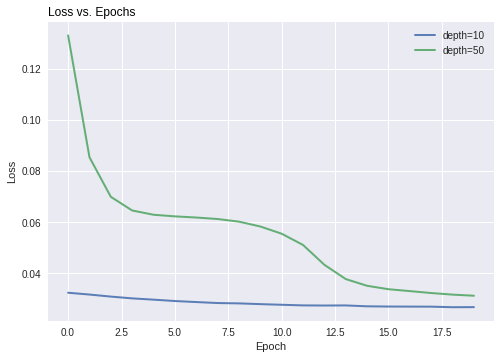

In [87]:
plt.style.use('seaborn')
palette = plt.get_cmap('Set1')


plt.plot(loss_10depth[9:], linewidth=2, alpha=0.9, label="depth=10")
plt.plot(loss_50depth[9:], linewidth=2, alpha=0.9, label="depth=50")
plt.legend(loc=1, ncol=1)

plt.title("Loss vs. Epochs", loc='left', fontsize=12, fontweight=0, color='black')
plt.xlabel("Epoch")
plt.ylabel("Loss")

## Visualization Images Deblurring
Load VOC dataset into data_loader

In [3]:

"""
Data_loader is iterable
[ (image1_tensor, label1_tensor), ...]
"""
# If you want path support different dataset, use below
# data_loader = generator.get_path_loader(1, DATA_PATH, shuffle=False)
data_loader = generator.get_VOC_loader(1, "val")
print(len(data_loader))

# Split for visualization
data_nparray = np.array([one_data[0].view(-1).numpy() for one_data in data_loader])
labels_nparray = np.array([one_data[1] for one_data in data_loader])




Using downloaded and verified file: ../data/VOCtrainval_11-May-2012.tar
1449


### Compares the original image, noised image and reconstruction image
Customized visualizing details are in visuals.py

  0%|          | 3/1449 [00:00<06:16,  3.84it/s]


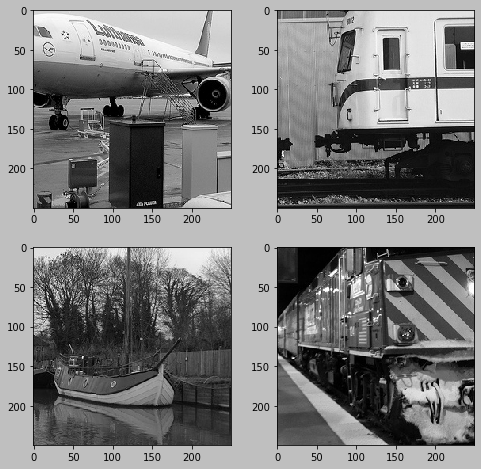

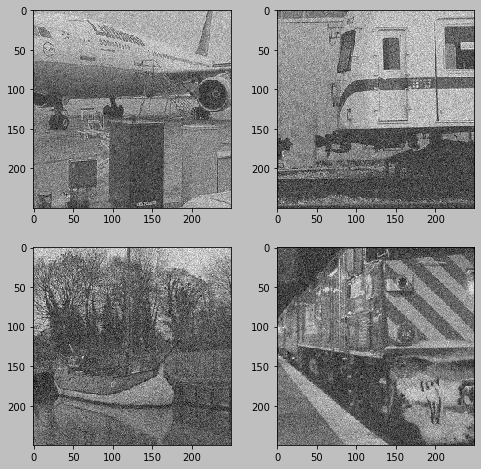

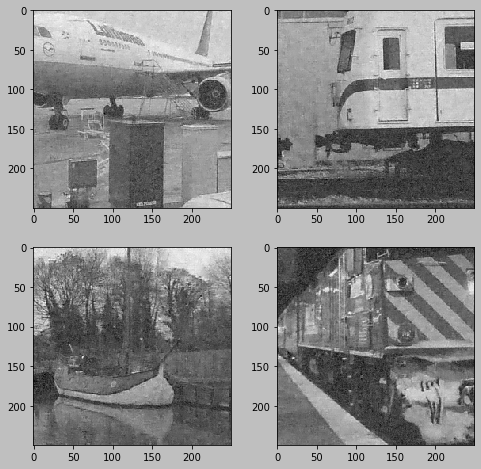

In [30]:
import visuals

test_img_list = []
noisy_img_list = []
embedding_model_np = []
img_model_np = []
num_data = 4
noiseSTD = 30

with torch.no_grad():
    for i, (img_test, _) in enumerate(tqdm(data_loader)):
        
        test_img_list.append(img_test.numpy())
        # Blurred the image with guassian noise         
        noisy_img = (img_test + noiseSTD / 255 * torch.randn(img_test.shape)).to(DEVICE)
        
        # Produce reconstruction + obtain sparse code
        img_new, x_new, _ = result_model(noisy_img)
        noisy_img_list.append(noisy_img.view(-1).to("cpu").detach().numpy())
        embedding_model_np.append(x_new.view(-1).to("cpu").detach().numpy())
        img_model_np.append(img_new.view(-1).to("cpu").detach().numpy())
        if i == num_data-1:
            break

embedding_model_np = np.array(embedding_model_np)

plt.style.use('grayscale')

# Visualize the image itself to see the noisy input
visuals.visualize_img(test_img_list, labels_nparray, (250,250))
visuals.visualize_img(noisy_img_list, labels_nparray, (250,250))
visuals.visualize_img(img_model_np, labels_nparray, (250,250))
    

In [53]:
print(x_new.size())

torch.Size([36, 64, 44, 44])


## Loading PSNR score (deblurring effect score)

In [90]:

FOLDER_PATH = "/home/garysnake/Desktop/crsae/pytorch/results/default/64_conv_10_depth/"

psnr_total = []

PSNR = np.load(FOLDER_PATH + "psnr_init.npy")

for i in range(29):
    PSNR = np.load(FOLDER_PATH + "psnr_epoch{}.npy".format(i))
    psnr_total.append(np.mean(PSNR))
    
np.array(psnr_total)
print(len(psnr_total))
print(np.mean(psnr_total))
print(psnr_total)


29
27.600800091954518
[25.899638023742927, 25.99368178768352, 26.098667121215307, 26.14615957725734, 26.208813989906474, 26.362052336553713, 26.4752326133096, 26.580531185690834, 26.82174355872721, 27.08729611312504, 27.32298525702658, 27.559394159330488, 27.69572153796742, 27.86464041187007, 27.976014215069817, 28.121628625642348, 28.200172240774517, 28.270139554071996, 28.337601301439616, 28.37158894923492, 28.43020138225349, 28.47604432947975, 28.494209611969644, 28.543517682129316, 28.58121184887348, 28.607212272527313, 28.600637038373964, 28.640531146200857, 28.655934795233364]


In [88]:
psnr_depth50 = psnr_total

In [92]:
psnr_depth10 = psnr_total

## Compares PSNR over epochs

Text(0, 0.5, 'Loss')

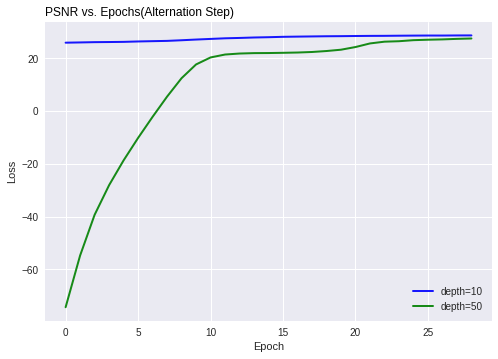

In [100]:
plt.style.use('seaborn')

fig = plt.figure()
ax = fig.add_subplot(111)

palette = plt.get_cmap('Set2')

# plt.plot(psnr_redo1,linewidth=2, marker = 'o', color='red', alpha=0.9, label="Step=1")
# plt.plot(psnr_redo5,linewidth=2, marker = 'v', color=palette(2), alpha=0.9, label="Step10")
# plt.plot(psnr_redo5_2,linewidth=2, marker = 's', color='purple', alpha=0.9, label="Step=5")
# plt.plot(psnr_redo10, color='green', marker = 'x', linewidth=2, alpha=0.9, label="Step=30")


plt.plot(psnr_depth10, color='blue', marker = 'x', linewidth=2, alpha=0.9, label="depth=10")
plt.plot(psnr_depth50, color='green', marker = 'x', linewidth=2, alpha=0.9, label="depth=50")

plt.legend(loc=4, ncol=1)

plt.title("PSNR vs. Epochs(Alternation Step)", loc='left', fontsize=12, fontweight=0, color='black')
plt.xlabel("Epoch")
plt.ylabel("Loss")




# Dictionary & Features 
Visualization

In [109]:
dictionary = result_model.get_param("Wd").data
print(dictionary.size())



torch.Size([64, 1, 7, 7])


In [110]:
# F.conv_transpose2d(x_new, result_model.get_param("Wd"), stride=result_model.stride)
# result_model.get_param("H").size()

print(x_new.size())
img_size = img_new.size()
print(img_size)


# Crucial - finding the correct size for the sparse code after padding
#  valids_batched is a boolean map that what signal in Hx should stay
_, valids_batched = visuals.split_image(noisy_img, result_model.stride, result_model.dictionary_dim, result_model.device)

# 36 64 44 44
# 64 1  7  7

# Dictionary atoms
dictionary_array = torch.split(dictionary, 1,0)

# Sparse code for each atom
x_sparse_code = torch.split(x_new, 1, 1)

features = []
for x_sparse, atom in zip(x_sparse_code, dictionary_array):
    conv_filter = F.conv_transpose2d(x_sparse, atom, stride=result_model.stride)
    conv_filter = torch.masked_select(conv_filter, valids_batched.bool()
                                     ).reshape(img_size[0], result_model.stride ** 2, *img_size[1:])
    conv_filter = conv_filter.mean(dim = 1,keepdim=False)
    features.append(conv_filter.view(-1).cpu().numpy())



torch.Size([36, 64, 44, 44])
torch.Size([1, 1, 250, 250])


In [174]:
# Pad the image back to normal size

# x_batched_padded, valids_batched = visuals.split_mage(x_new, result_model.stride, result_model.dictionary_dim, result_model.device)



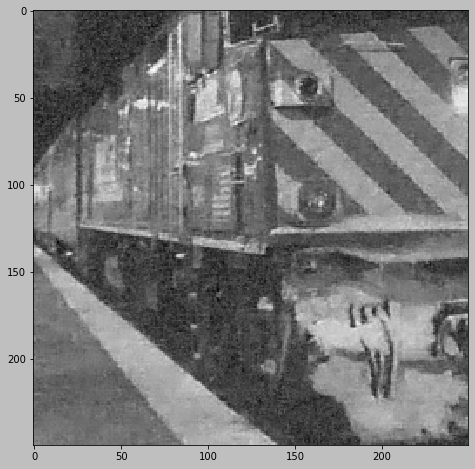

In [92]:


temp_img_new = torch.masked_select(
                                F.conv_transpose2d(x_new, result_model.get_param("Wd"), stride=result_model.stride),
                                valids_batched.bool()
                                ).reshape(noisy_img.shape[0], result_model.stride ** 2, *noisy_img.shape[1:]
                                ).mean(dim=1, keepdim=False)
            
            
visuals.visualize_img([temp_img_new.view(-1).cpu().detach().numpy()], [0], (250,250))

## Filters and Features below
First image shows all the filters before applying sparse code convolution,
Second image shows the feature after applying convolution

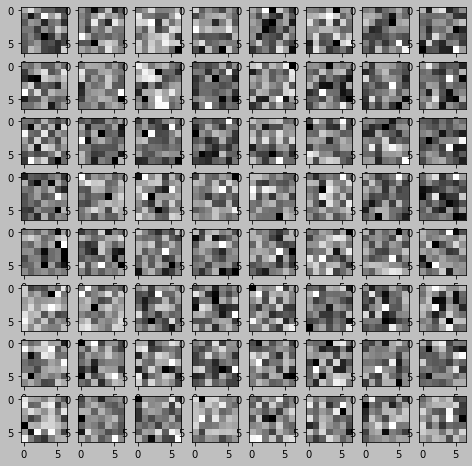

In [82]:
visuals.visualize_dictionary(dictionary.cpu().squeeze(dim=1))

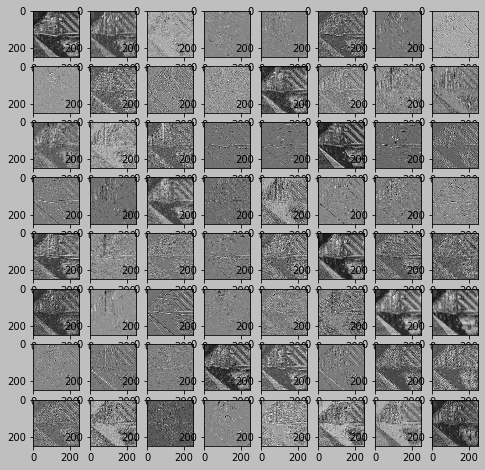

In [111]:
filter_size = int(np.sqrt(features[0].size))
visuals.visualize_img(features, list(range(len(features))), (filter_size, filter_size))


# Image Constructions from stacking convoluted filters

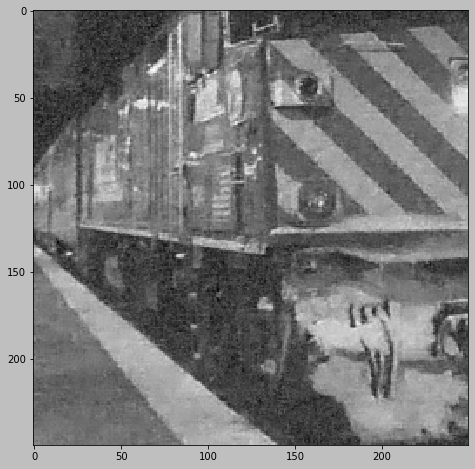

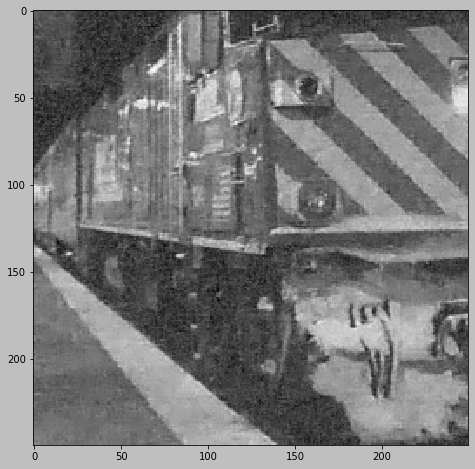

In [113]:
# Visualize the new image
img_size = img_new.size()[2]
visuals.visualize_img([img_new.view(-1).cpu().detach().numpy()], [0], (img_size,img_size))

# Visualize the reconstructed image
combine = np.array(features)
combine_pics = np.mean(combine, axis=0)
visuals.visualize_img([combine_pics], [1], (filter_size, filter_size))
